# Stanと ~R~ Pythonでベイズ統計モデリング

## 目的

2.のp64

二つの説明変数AとScoreで目的変数がどれだけ予測できるのか知りたいとする。

ただし目的変数は、Mを固定した時のYとする。

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import pystan

from criterion import Criterion

from pathlib import Path

plt.style.use("ggplot")
%matplotlib inline

In [2]:
read_path = "input/data-attendance-2.txt"
data_path = Path(os.getcwd(), read_path)
data = pd.read_csv(data_path)

In [3]:
# ratio 列の追加
data["retio"] = data["Y"]/data["M"]

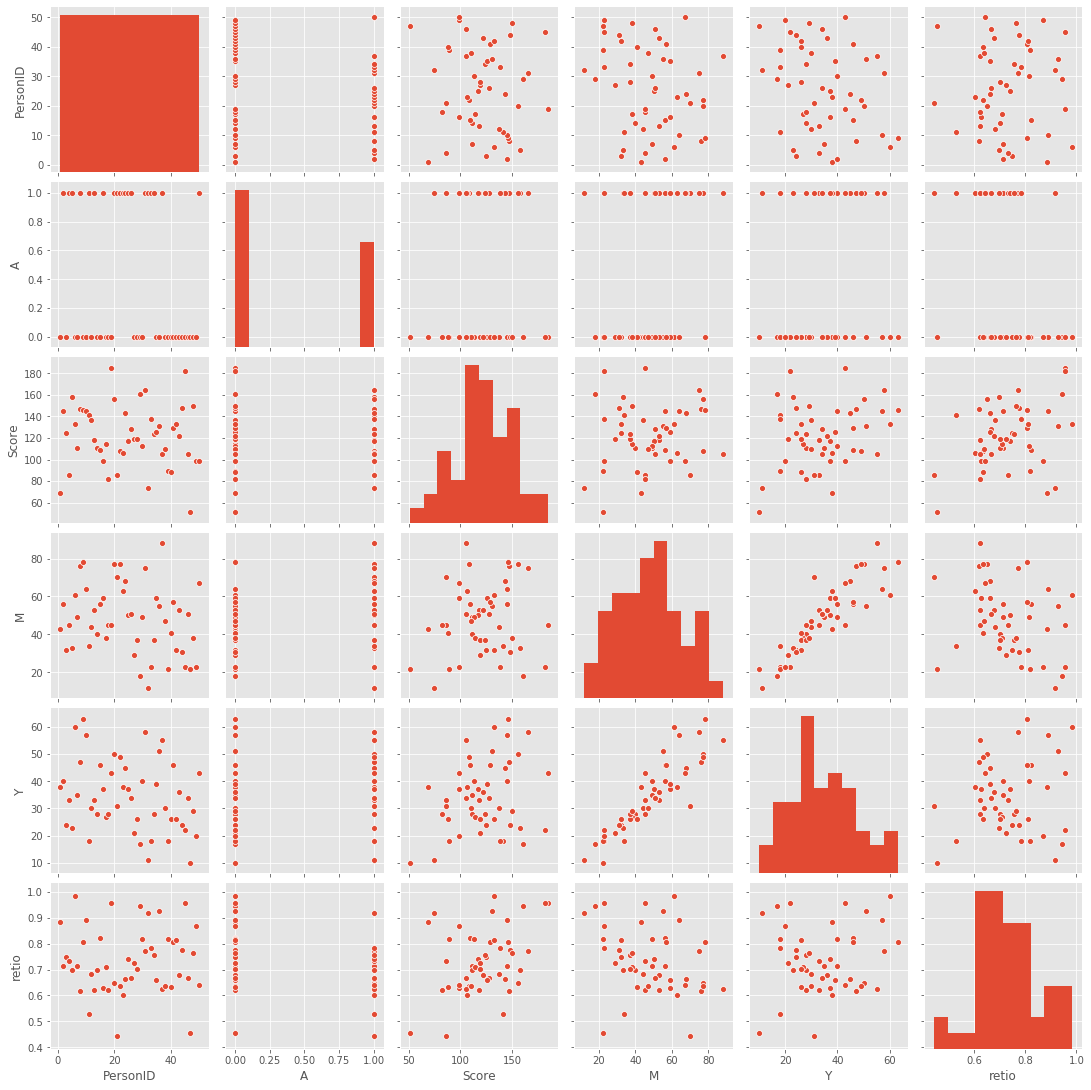

In [4]:
# 散布図行列
sns.pairplot(data)

- PersonID: 学生のID
- M : 3ヶ月間における履修登録した科目の総授業回数
- Y : そのうち実際に出席した回数
- A : アルバイトが好きかどうか
- score :　学問への興味の強さを表したもの

 ### modeling
 
今回のデータでは、授業回数が比較的少なく出席率を連続値とみなすのは厳しく、正規分布モデルはよく当てはまってないと考えられるので二項分布を使う。
 
本来はカウントデータなので、二項分布を使う方が良いが、大きいデータになれば二項分布は正規分布で近似する。（ある程度の妥協）

（正規分布を使う方が計算が早いらしい。。）

モデルは

- 説明変数AとScoreの線形結合$(b_1 + b_2 A[n] + b_3 Score[n]$)

- リンク関数はロジスティク関数で(0,1)の範囲に押し込んで確率？を考える。

In [5]:
def logistic_func(x):
    return 1/(1+np.exp(-x))

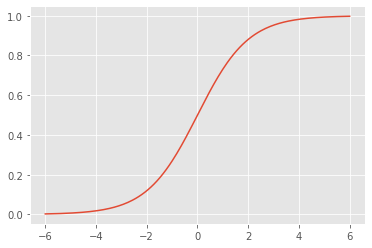

In [6]:
# logistic関数の可視化

x = np.linspace(-6, 6, 200)
fx = logistic_func(x)
plt.plot(x, fx)
plt.show()

モデル式は、[5.4]

$$q[n] = inv\_logit(b_{1} + b_{2} A[n] + b_{3} Score[n] $$
$$n = 1 , \dots , n $$

In [24]:
# modelを記述した読み込みたいstanファイル
read_stanmodel = "model5-3.stan"
# モデルをセーブしておくpickleファイル
read_file = "model5-3.pkl"

stan_path = Path(os.getcwd(),"model", read_stanmodel)
pickle_path = Path(os.getcwd(),"model", read_file)

try:
    with open(pickle_path, "rb") as f:
        stanmodel = pickle.load(f)

except FileNotFoundError:
    print("save path to stan file is ", stan_path)
    stanmodel = pystan.StanModel(
        file = str(stan_path),
    )
    with open(pickle_path, "wb") as f:
        pickle.dump(stanmodel, f)

In [12]:
standata = {"N":len(data), "A":data["A"], "Score":data["Score"]/200, "M":data["M"], "Y":data["Y"]}
fit = stanmodel.sampling(
    data=standata,
    iter=1000,
    warmup=200,
    seed=496,
)

In [13]:
print(fit)

Inference for Stan model: anon_model_a2cbc75e54b6f8e3cab79516779d33b4.
4 chains, each with iter=1000; warmup=200; thin=1; 
post-warmup draws per chain=800, total post-warmup draws=3200.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1           0.09  6.6e-3   0.23  -0.35  -0.06   0.09   0.24   0.56   1231    1.0
b2          -0.62  2.7e-3   0.09  -0.81  -0.68  -0.62  -0.55  -0.42   1222    1.0
b3            1.9    0.01   0.37   1.16   1.65    1.9   2.15   2.61   1287    1.0
q[1]         0.68  7.1e-4   0.02   0.63   0.66   0.68   0.69   0.73   1236    1.0
q[2]          0.7  4.1e-4   0.02   0.67   0.69    0.7   0.71   0.73   1598    1.0
q[3]         0.78  2.8e-4   0.01   0.76   0.77   0.78   0.79    0.8   1736    1.0
q[4]         0.57  5.6e-4   0.02   0.53   0.56   0.57   0.59   0.62   1572    1.0
q[5]         0.73  4.8e-4   0.02   0.69   0.71   0.73   0.74   0.76   1469    1.0
q[6]         0.79  2.8e-4   0.01   0.77   0.79    0.8    0.8   0.82   1816 

In [14]:
inference_data = fit.extract()

In [40]:
pd.DataFrame(data=np.mean(inference_data["y_pred"], axis=0))

,0
0,29.161875
1,39.301875
2,24.965312
3,25.818438
4,23.952813
5,48.460313
6,37.113125
7,53.526250
8,63.678125
9,52.081875


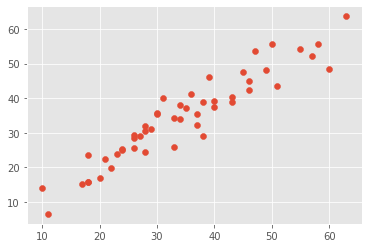

In [42]:
plt.scatter(data["Y"], np.mean(inference_data["y_pred"], axis=0))

y = x の直線上にはいい感じで乗ってそう。

pythonでRみたいな図を書くのが課題。